<a href="https://colab.research.google.com/github/abhinavdayal/EVA4/blob/master/S10/EVA04_S10_Resnet18_Albumentations_Gradcam_LRFinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

cloning  github repository and adding path to our system

In [1]:
!git clone https://github.com/abhinavdayal/EVA4_LIBRARY.git
import sys
sys.path.append("/content/EVA4_LIBRARY/EVA4")

Cloning into 'EVA4_LIBRARY'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 35 (delta 8), reused 15 (delta 6), pack-reused 0
Unpacking objects: 100% (35/35), done.


In [2]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-thqkpyna
All libraries are successfully installed!


In [3]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [0]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [4]:
import numpy as np
from eva4datatransforms import AlbumentationTransforms
import albumentations as A

channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
# Train Phase transformations
train_transforms = AlbumentationTransforms([
                                       A.Rotate((-30.0, 30.0)),
                                       A.HorizontalFlip(),
                                       A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=4) # fillvalue is 0 after normalizing as mean is 0
                                       ])

fillmeans = (np.array(channel_means)).astype(np.uint8)



# Test Phase transformations
test_transforms = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])



# Dataset and Creating Train/Test Split

In [5]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
import eva4dataloaders

dataloader = eva4dataloaders.DataLoader(batch_size=128)

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

In [0]:
import numpy as np
dataiter = iter(train_loader)
images, labels = dataiter.next()
i = images[90].numpy()
print(np.max(i), np.min(i))

2.1267893 -1.9892128


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

torch.Size([128, 3, 32, 32])
torch.Size([128])


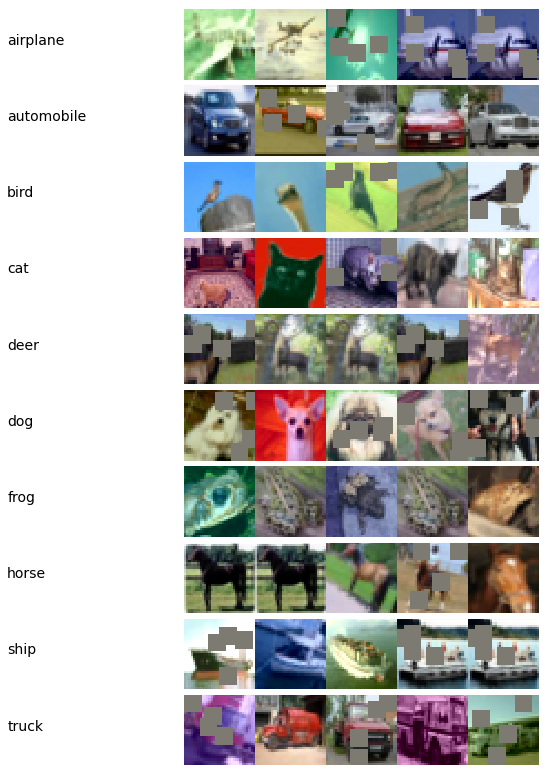

In [26]:
from __future__ import print_function
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

# The model

## Target
1. Less than 7000 parameters
2. Less than 15 epochs
3. Test with Cyclic LR
4. Add small dropout of 6%

## Results
1. Number of Parameters = 6202 + 140 non trainable BN params
2. Best Train Accuracy = 98.97
3. Best Test Accuracy = 99.45

## Analysis
1. We pushed the model to achieve target with approx 6000 Parameters
2. Drop in accuracy was predicted because of making the training more difficult. But still we met the target.

# Model Creation

We will be creating Resnet18 model here.

We replaced FC with 1x1 as we are not supposed to use FC in this EVA4.

In [8]:
from eva4models import eva4resnet
import torch
model = eva4resnet.ResNet18(name="s10model")
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


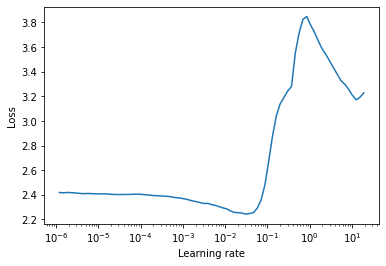

In [9]:
# LR finder fast ai approach
from eva4LRFinder import LRFinder
import torch.optim as optim
import torch.nn as nn
L1lambda = 0
L2lambda = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, nesterov=True, weight_decay=L2lambda)
lr_finder = LRFinder(model, optimizer, criterion, device=model.device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [0]:
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
#lr[loss.index(min(loss))]
optimizer = optim.SGD(model.parameters(), lr=lr[loss.index(min(loss))], momentum=0.9, nesterov=True, weight_decay=L2lambda)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [12]:
#from torch.optim.lr_scheduler import StepLR

from torch.optim.lr_scheduler import ReduceLROnPlateau
EPOCHS = 50
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)
scheduler = ReduceLROnPlateau(optimizer, min_lr=1e-7, patience = 2, verbose=True)

model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, False, L1lambda)


In scheduler step with loss of  1.2558550548553467
Validation loss decreased (100000.000000 --> 1.255855).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0119, Accuracy: 45.68%; Test set: Average loss: 1.2559, Accuracy: 57.35%
Learning Rate = 0.030903



In scheduler step with loss of  0.806337091255188
Validation loss decreased (1.255855 --> 0.806337).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0081, Accuracy: 63.88%; Test set: Average loss: 0.8063, Accuracy: 72.15%
Learning Rate = 0.030903



In scheduler step with loss of  0.749152220249176
Validation loss decreased (0.806337 --> 0.749152).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0066, Accuracy: 70.37%; Test set: Average loss: 0.7492, Accuracy: 74.36%
Learning Rate = 0.030903



In scheduler step with loss of  0.6288505291938782
Validation loss decreased (0.749152 --> 0.628851).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0058, Accuracy: 74.21%; Test set: Average loss: 0.6289, Accuracy: 78.29%
Learning Rate = 0.030903



In scheduler step with loss of  0.6111818076610566
Validation loss decreased (0.628851 --> 0.611182).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0053, Accuracy: 76.48%; Test set: Average loss: 0.6112, Accuracy: 79.68%
Learning Rate = 0.030903



In scheduler step with loss of  0.6995669357299805
Epoch: 6, Train set: Average loss: 0.0049, Accuracy: 78.46%; Test set: Average loss: 0.6996, Accuracy: 76.45%
Learning Rate = 0.030903



In scheduler step with loss of  0.6366872066497803
Epoch: 7, Train set: Average loss: 0.0045, Accuracy: 80.26%; Test set: Average loss: 0.6367, Accuracy: 79.68%
Learning Rate = 0.030903



In scheduler step with loss of  0.5493464260101318
Validation loss decreased (0.611182 --> 0.549346).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0042, Accuracy: 81.28%; Test set: Average loss: 0.5493, Accuracy: 82.22%
Learning Rate = 0.030903



In scheduler step with loss of  0.4589020143032074
Validation loss decreased (0.549346 --> 0.458902).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0039, Accuracy: 82.46%; Test set: Average loss: 0.4589, Accuracy: 84.67%
Learning Rate = 0.030903



In scheduler step with loss of  0.44690501046180725
Validation loss decreased (0.458902 --> 0.446905).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0037, Accuracy: 83.79%; Test set: Average loss: 0.4469, Accuracy: 85.54%
Learning Rate = 0.030903



In scheduler step with loss of  0.4475142763137817
Epoch: 11, Train set: Average loss: 0.0035, Accuracy: 84.53%; Test set: Average loss: 0.4475, Accuracy: 85.29%
Learning Rate = 0.030903



In scheduler step with loss of  0.425986993932724
Validation loss decreased (0.446905 --> 0.425987).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0033, Accuracy: 85.23%; Test set: Average loss: 0.4260, Accuracy: 85.64%
Learning Rate = 0.030903



In scheduler step with loss of  0.4068745695590973
Validation loss decreased (0.425987 --> 0.406875).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0032, Accuracy: 85.72%; Test set: Average loss: 0.4069, Accuracy: 86.54%
Learning Rate = 0.030903



In scheduler step with loss of  0.37747755270004274
Validation loss decreased (0.406875 --> 0.377478).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0031, Accuracy: 86.45%; Test set: Average loss: 0.3775, Accuracy: 87.40%
Learning Rate = 0.030903



In scheduler step with loss of  0.444848810005188
Epoch: 15, Train set: Average loss: 0.0029, Accuracy: 87.18%; Test set: Average loss: 0.4448, Accuracy: 85.60%
Learning Rate = 0.030903



In scheduler step with loss of  0.3621585329055786
Validation loss decreased (0.377478 --> 0.362159).  Saving model ...
Epoch: 16, Train set: Average loss: 0.0027, Accuracy: 87.84%; Test set: Average loss: 0.3622, Accuracy: 88.13%
Learning Rate = 0.030903



In scheduler step with loss of  0.36208058891296385
Validation loss decreased (0.362159 --> 0.362081).  Saving model ...
Epoch: 17, Train set: Average loss: 0.0027, Accuracy: 88.14%; Test set: Average loss: 0.3621, Accuracy: 88.19%
Learning Rate = 0.030903



In scheduler step with loss of  0.39867332837581637
Epoch: 18, Train set: Average loss: 0.0025, Accuracy: 88.86%; Test set: Average loss: 0.3987, Accuracy: 87.36%
Learning Rate = 0.030903



In scheduler step with loss of  0.3667451125144959
Epoch: 19, Train set: Average loss: 0.0024, Accuracy: 89.19%; Test set: Average loss: 0.3667, Accuracy: 88.20%
Learning Rate = 0.030903



In scheduler step with loss of  0.369726473236084
Epoch    20: reducing learning rate of group 0 to 3.0903e-03.
Epoch: 20, Train set: Average loss: 0.0023, Accuracy: 89.47%; Test set: Average loss: 0.3697, Accuracy: 87.94%
Learning Rate = 0.003090



In scheduler step with loss of  0.2701169575214386
Validation loss decreased (0.362081 --> 0.270117).  Saving model ...
Epoch: 21, Train set: Average loss: 0.0018, Accuracy: 92.25%; Test set: Average loss: 0.2701, Accuracy: 91.30%
Learning Rate = 0.003090



In scheduler step with loss of  0.26295856606960294
Validation loss decreased (0.270117 --> 0.262959).  Saving model ...
Epoch: 22, Train set: Average loss: 0.0015, Accuracy: 93.23%; Test set: Average loss: 0.2630, Accuracy: 91.74%
Learning Rate = 0.003090



In scheduler step with loss of  0.2619244048595428
Validation loss decreased (0.262959 --> 0.261924).  Saving model ...
Epoch: 23, Train set: Average loss: 0.0015, Accuracy: 93.42%; Test set: Average loss: 0.2619, Accuracy: 91.87%
Learning Rate = 0.003090



In scheduler step with loss of  0.2587623131275177
Validation loss decreased (0.261924 --> 0.258762).  Saving model ...
Epoch: 24, Train set: Average loss: 0.0014, Accuracy: 93.91%; Test set: Average loss: 0.2588, Accuracy: 91.95%
Learning Rate = 0.003090



In scheduler step with loss of  0.2590574424028397
Epoch: 25, Train set: Average loss: 0.0014, Accuracy: 94.08%; Test set: Average loss: 0.2591, Accuracy: 91.99%
Learning Rate = 0.003090



In scheduler step with loss of  0.257206680059433
Validation loss decreased (0.258762 --> 0.257207).  Saving model ...
Epoch: 26, Train set: Average loss: 0.0013, Accuracy: 94.53%; Test set: Average loss: 0.2572, Accuracy: 92.02%
Learning Rate = 0.003090



In scheduler step with loss of  0.2558775894165039
Validation loss decreased (0.257207 --> 0.255878).  Saving model ...
Epoch: 27, Train set: Average loss: 0.0013, Accuracy: 94.35%; Test set: Average loss: 0.2559, Accuracy: 92.19%
Learning Rate = 0.003090



In scheduler step with loss of  0.26086245131492614
Epoch: 28, Train set: Average loss: 0.0012, Accuracy: 94.74%; Test set: Average loss: 0.2609, Accuracy: 91.99%
Learning Rate = 0.003090



In scheduler step with loss of  0.2550294522285461
Validation loss decreased (0.255878 --> 0.255029).  Saving model ...
Epoch: 29, Train set: Average loss: 0.0012, Accuracy: 94.80%; Test set: Average loss: 0.2550, Accuracy: 92.20%
Learning Rate = 0.003090



In scheduler step with loss of  0.259551420211792
Epoch: 30, Train set: Average loss: 0.0012, Accuracy: 94.84%; Test set: Average loss: 0.2596, Accuracy: 92.05%
Learning Rate = 0.003090



In scheduler step with loss of  0.25577215418815613
Epoch: 31, Train set: Average loss: 0.0011, Accuracy: 94.90%; Test set: Average loss: 0.2558, Accuracy: 92.13%
Learning Rate = 0.003090



In scheduler step with loss of  0.2559212392807007
Epoch    32: reducing learning rate of group 0 to 3.0903e-04.
Epoch: 32, Train set: Average loss: 0.0011, Accuracy: 94.86%; Test set: Average loss: 0.2559, Accuracy: 92.21%
Learning Rate = 0.000309



In scheduler step with loss of  0.25206937408447266
Validation loss decreased (0.255029 --> 0.252069).  Saving model ...
Epoch: 33, Train set: Average loss: 0.0011, Accuracy: 95.30%; Test set: Average loss: 0.2521, Accuracy: 92.33%
Learning Rate = 0.000309



In scheduler step with loss of  0.2512802464485168
Validation loss decreased (0.252069 --> 0.251280).  Saving model ...
Epoch: 34, Train set: Average loss: 0.0011, Accuracy: 95.30%; Test set: Average loss: 0.2513, Accuracy: 92.30%
Learning Rate = 0.000309



In scheduler step with loss of  0.25024865217208864
Validation loss decreased (0.251280 --> 0.250249).  Saving model ...
Epoch: 35, Train set: Average loss: 0.0011, Accuracy: 95.42%; Test set: Average loss: 0.2502, Accuracy: 92.31%
Learning Rate = 0.000309



In scheduler step with loss of  0.25144745998382567
Epoch: 36, Train set: Average loss: 0.0010, Accuracy: 95.52%; Test set: Average loss: 0.2514, Accuracy: 92.32%
Learning Rate = 0.000309



In scheduler step with loss of  0.25037313270568845
Epoch: 37, Train set: Average loss: 0.0011, Accuracy: 95.28%; Test set: Average loss: 0.2504, Accuracy: 92.46%
Learning Rate = 0.000309



In scheduler step with loss of  0.2501887006759644
Validation loss decreased (0.250249 --> 0.250189).  Saving model ...
Epoch: 38, Train set: Average loss: 0.0010, Accuracy: 95.47%; Test set: Average loss: 0.2502, Accuracy: 92.45%
Learning Rate = 0.000309



In scheduler step with loss of  0.25048298077583314
Epoch: 39, Train set: Average loss: 0.0010, Accuracy: 95.49%; Test set: Average loss: 0.2505, Accuracy: 92.41%
Learning Rate = 0.000309



In scheduler step with loss of  0.2506673725605011
Epoch: 40, Train set: Average loss: 0.0010, Accuracy: 95.45%; Test set: Average loss: 0.2507, Accuracy: 92.40%
Learning Rate = 0.000309



In scheduler step with loss of  0.2515723618268967
Epoch    41: reducing learning rate of group 0 to 3.0903e-05.
Epoch: 41, Train set: Average loss: 0.0010, Accuracy: 95.64%; Test set: Average loss: 0.2516, Accuracy: 92.45%
Learning Rate = 0.000031



In scheduler step with loss of  0.2514494686126709
Epoch: 42, Train set: Average loss: 0.0010, Accuracy: 95.59%; Test set: Average loss: 0.2514, Accuracy: 92.40%
Learning Rate = 0.000031



In scheduler step with loss of  0.25077968752384183
Epoch: 43, Train set: Average loss: 0.0010, Accuracy: 95.70%; Test set: Average loss: 0.2508, Accuracy: 92.42%
Learning Rate = 0.000031



In scheduler step with loss of  0.24981200578212737
Validation loss decreased (0.250189 --> 0.249812).  Saving model ...
Epoch: 44, Train set: Average loss: 0.0010, Accuracy: 95.54%; Test set: Average loss: 0.2498, Accuracy: 92.36%
Learning Rate = 0.000031



In scheduler step with loss of  0.2493136474132538
Validation loss decreased (0.249812 --> 0.249314).  Saving model ...
Epoch: 45, Train set: Average loss: 0.0010, Accuracy: 95.55%; Test set: Average loss: 0.2493, Accuracy: 92.46%
Learning Rate = 0.000031



In scheduler step with loss of  0.2517557864189148
Epoch: 46, Train set: Average loss: 0.0010, Accuracy: 95.48%; Test set: Average loss: 0.2518, Accuracy: 92.41%
Learning Rate = 0.000031



In scheduler step with loss of  0.25118852677345277
Epoch: 47, Train set: Average loss: 0.0010, Accuracy: 95.42%; Test set: Average loss: 0.2512, Accuracy: 92.46%
Learning Rate = 0.000031



In scheduler step with loss of  0.24969359221458434
Epoch    48: reducing learning rate of group 0 to 3.0903e-06.
Epoch: 48, Train set: Average loss: 0.0010, Accuracy: 95.43%; Test set: Average loss: 0.2497, Accuracy: 92.42%
Learning Rate = 0.000003



In scheduler step with loss of  0.2505304503917694
Epoch: 49, Train set: Average loss: 0.0010, Accuracy: 95.47%; Test set: Average loss: 0.2505, Accuracy: 92.47%
Learning Rate = 0.000003



In scheduler step with loss of  0.24990521516799927
Epoch: 50, Train set: Average loss: 0.0010, Accuracy: 95.50%; Test set: Average loss: 0.2499, Accuracy: 92.41%
Learning Rate = 0.000003



## Plots for Learning rate vs Accuracy/Loss

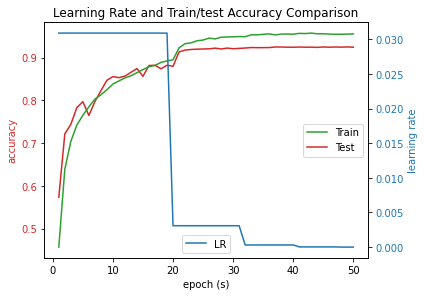

In [70]:
fig, ax1 = plt.subplots()
t = np.arange(1, 51)
color = 'tab:red'
ax1.set_xlabel('epoch (s)')
ax1.set_ylabel('accuracy', color=color)
testline, = ax1.plot(t, model.stats().test_acc, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:green'
trainline, = ax1.plot(t, model.stats().train_acc, color=color)
ax1.legend((trainline, testline), ('Train', 'Test'), loc=7)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)  # we already handled the x-label with ax1
lrline, = ax2.plot(t, model.stats().lr, color=color)
ax2.legend((lrline, ), ('LR',), loc=8)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Learning Rate and Train/test Accuracy Comparison")
plt.show()

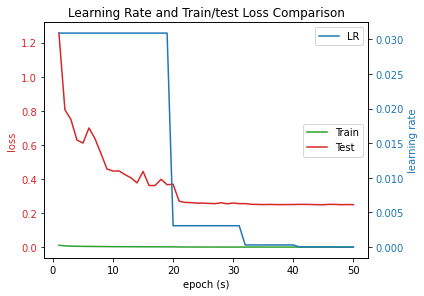

In [69]:
fig, ax1 = plt.subplots()
t = np.arange(1, 51)
color = 'tab:red'
ax1.set_xlabel('epoch (s)')
ax1.set_ylabel('loss', color=color)
testline, = ax1.plot(t, model.stats().avg_test_loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:green'
trainline, = ax1.plot(t, model.stats().avg_train_loss, color=color)
ax1.legend((trainline, testline), ('Train', 'Test'), loc=7)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)  # we already handled the x-label with ax1
lrline, = ax2.plot(t, model.stats().lr, color=color)
ax2.legend((lrline, ), ('LR',), loc=1)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Learning Rate and Train/test Loss Comparison")
plt.show()

# Conclusions

The results clearly indicate overfitting. This we need to address probably using regulaization or more rigorous augmentation. One issue is the image sizes being too small 32x32 for the resnet18 with a very high receptive field. Probably a simpler model would work better.

# GRAD CAM

In [13]:
len(model.stats().get_misclassified_images())

25

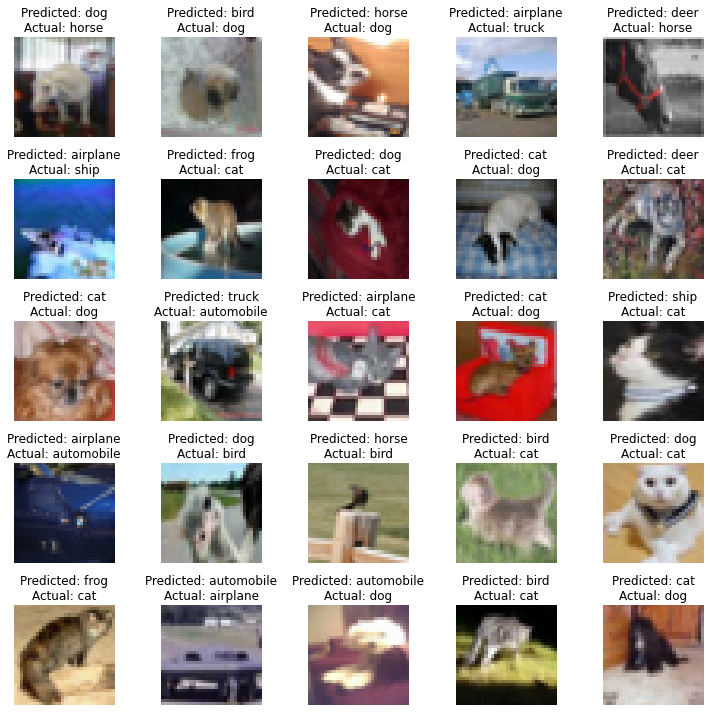

In [14]:
import plots
plots.plot_images(model.stats().get_misclassified_images(), class_names, "misclassified_imgs.png", mean=list(channel_means), std=list(channel_stdevs))

In [0]:
mimages = model.stats().get_misclassified_images()
images = []
target_classes = []
pred_classes = []
for i in mimages:
  images.append(i["img"].cpu())
  target_classes.append(int(i['target']))
  pred_classes.append(int(i['pred']))

In [39]:
print(target_classes)
print(pred_classes)

[7, 5, 5, 9, 7, 8, 3, 3, 5, 3, 5, 1, 3, 5, 3, 1, 2, 2, 3, 3, 3, 0, 5, 3, 5]
[5, 2, 7, 0, 4, 0, 6, 5, 3, 4, 3, 9, 0, 3, 8, 0, 5, 7, 2, 5, 6, 1, 1, 2, 3]


torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


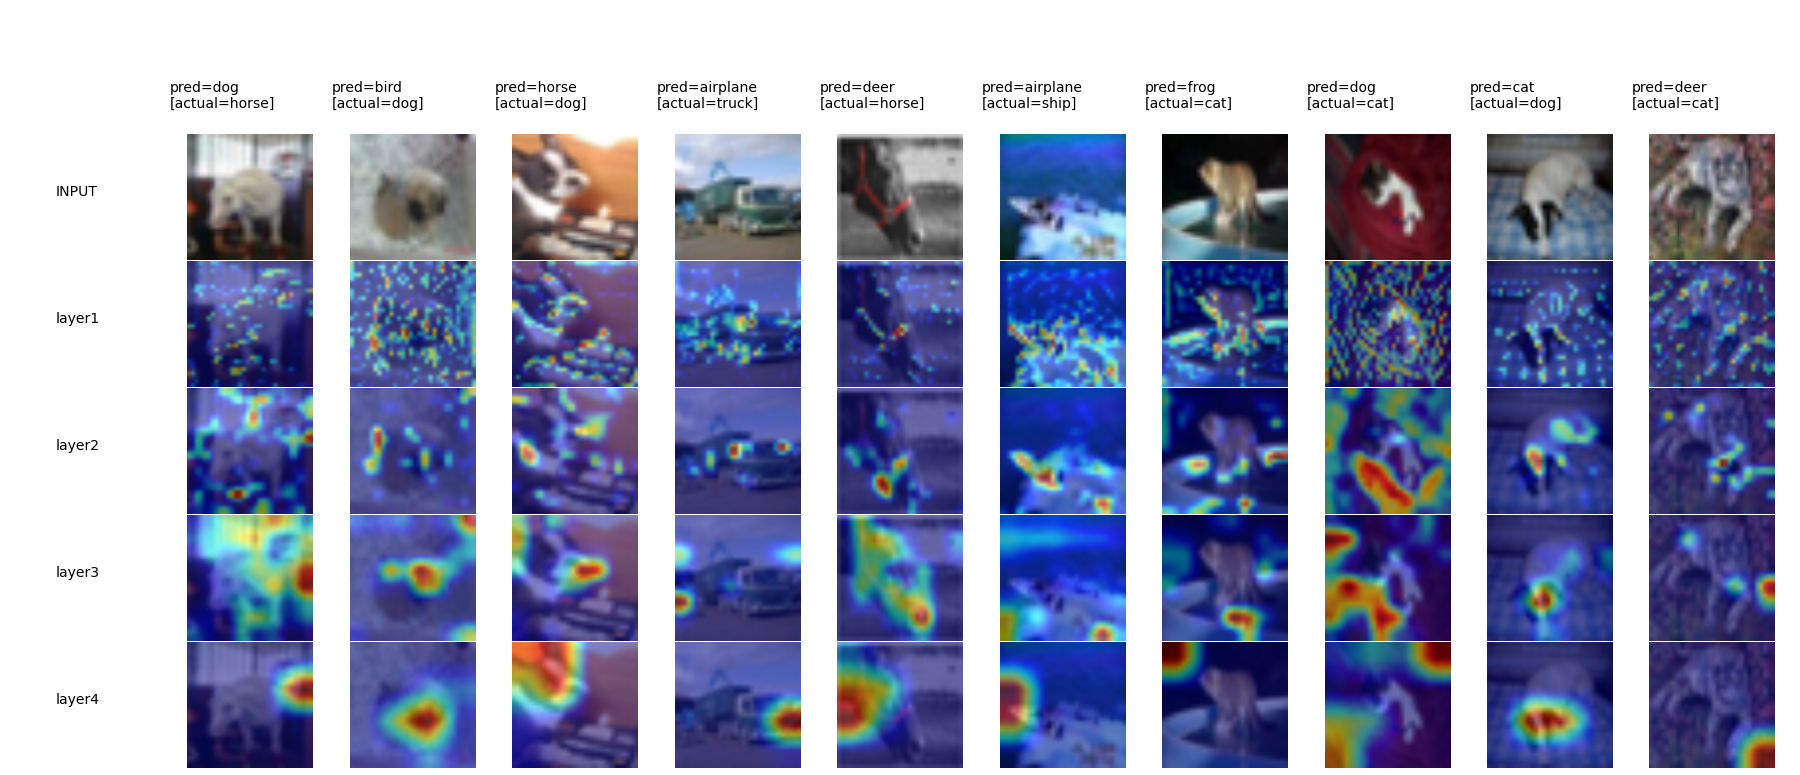

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


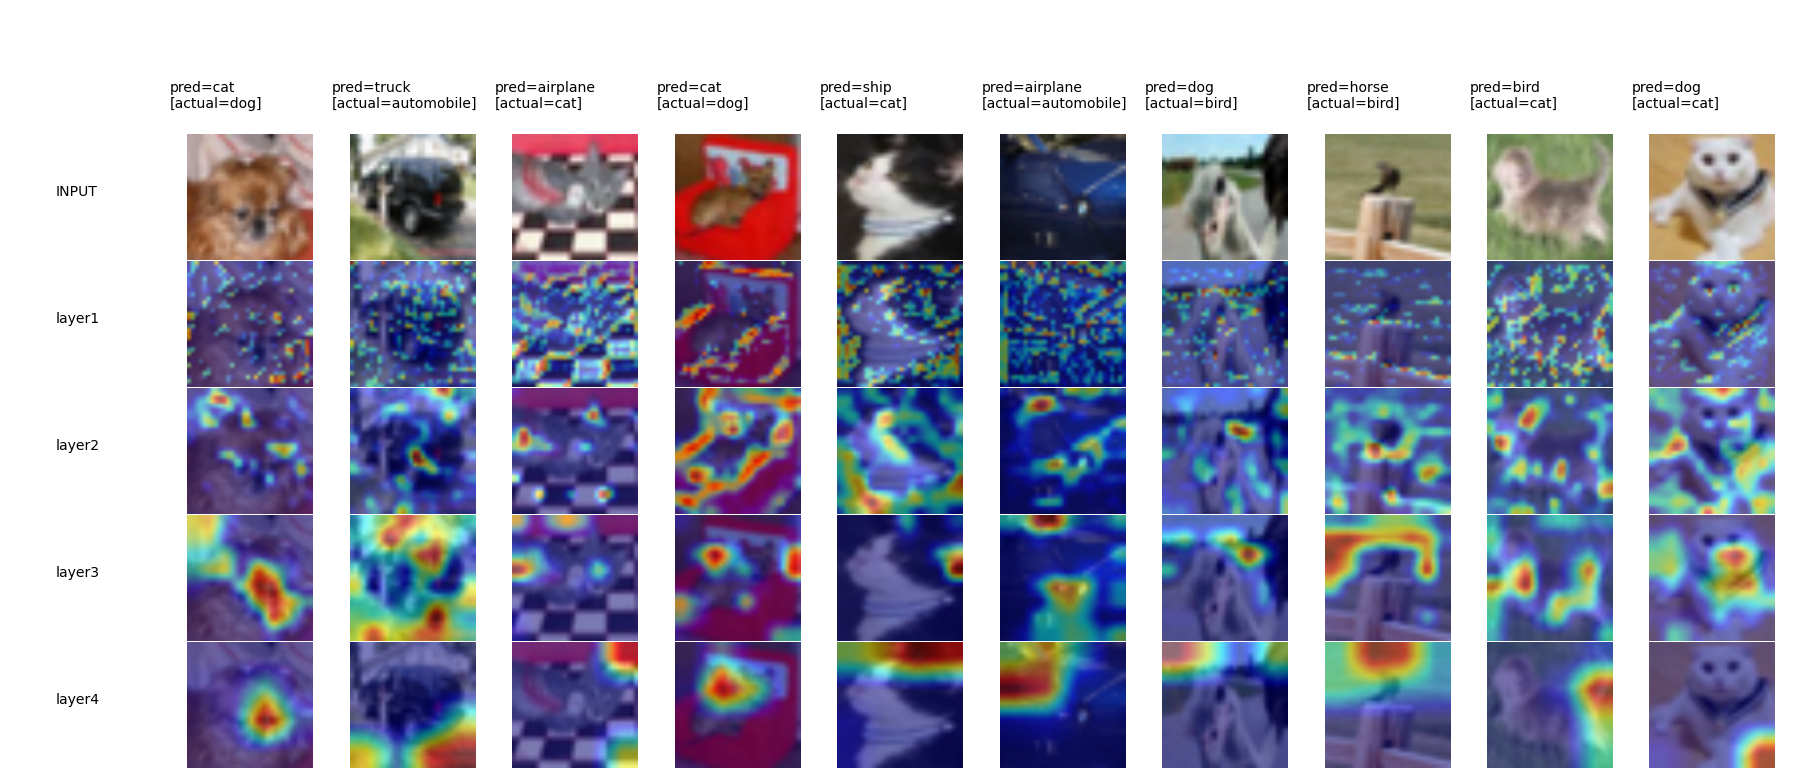

torch.Size([5, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


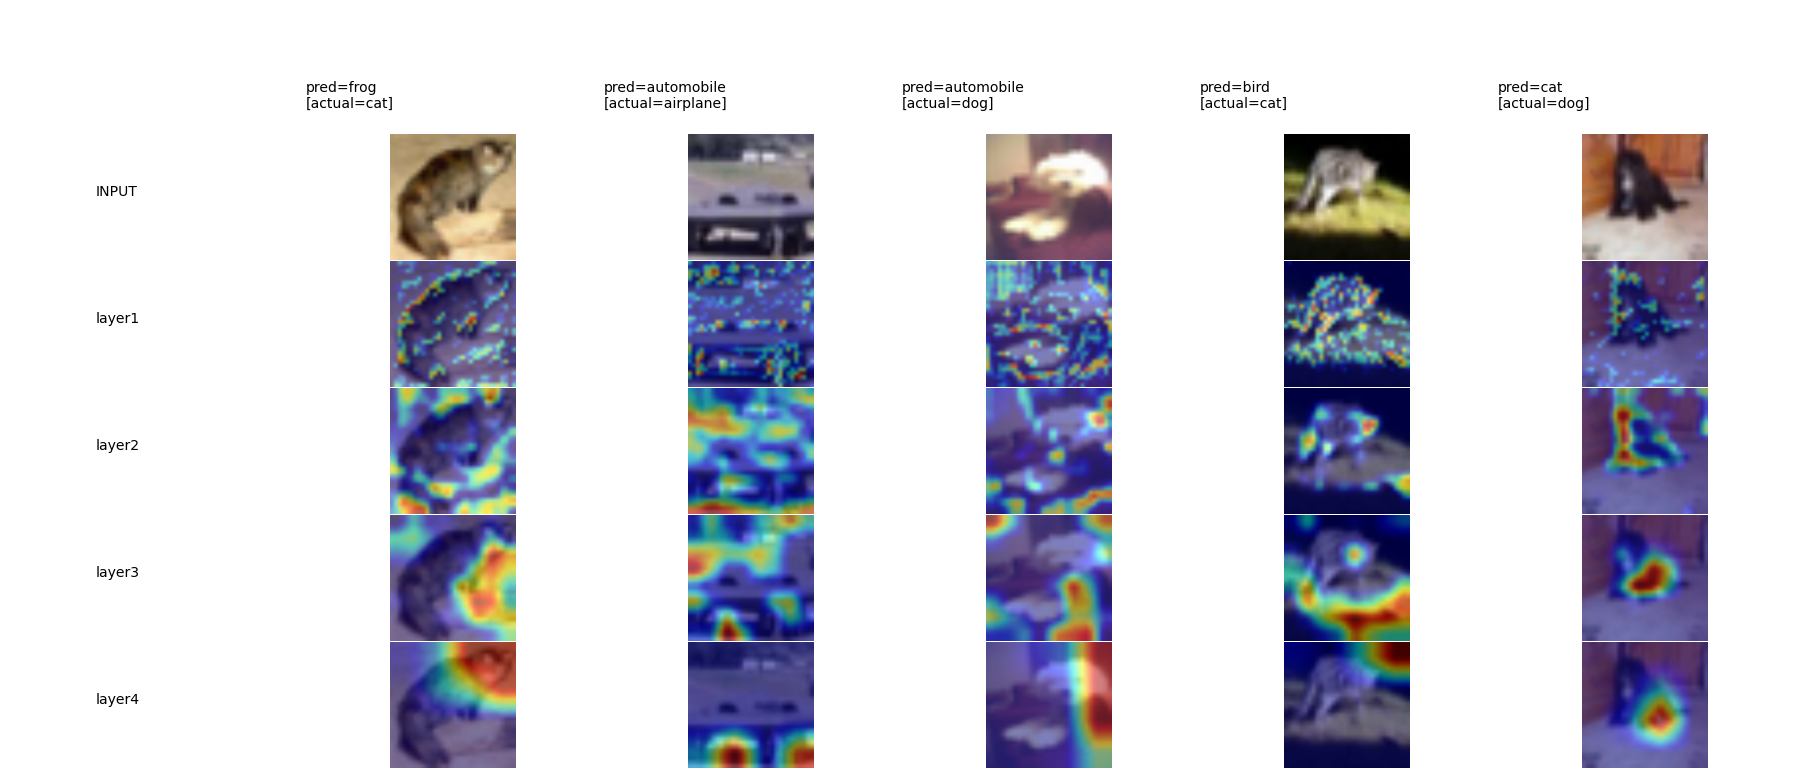

In [40]:
from eva4gradcam import GRADCAM, PLOT
target_layers = ["layer1", "layer2", "layer3", "layer4"]
#Gradcam plot for first 10 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[:10], target_classes[:10], model, target_layers)
PLOT(gradcam_output, images[:10], target_classes[:10], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)
#Gradcam plot for 11-20 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[10:20], target_classes[10:20], model, target_layers)
PLOT(gradcam_output, images[10:20], target_classes[10:20], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)
#Gradcam plot for 21-25 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[20:], target_classes[20:], model, target_layers)
PLOT(gradcam_output, images[20:], target_classes[20:], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)